In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import preprocessing
import datetime as dt
import os
import statsmodels.api as sm
import scipy.optimize as optim
import datetime
import urllib

In [3]:

datalink='https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx'
urllib.request.urlretrieve(datalink, "covid.xls")
df = pd.read_excel('covid.xls')

In [4]:
dfbg = df.loc[df['geoId']=='BG']

In [5]:
dfbg.index = dfbg['dateRep']
dfbg.index = pd.to_datetime(dfbg.index)
dfbg = dfbg.sort_index()
dfbg['cumcases'] = dfbg['cases'].cumsum()
dfbg = dfbg[dfbg.cumcases != 0]
dfbg['passed_days'] = np.arange(1, len(dfbg)+1)
dfbg.head(5)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp,cumcases,passed_days
dateRep,,,,,,,,,,,,,
2020-03-08,2020-03-08,8,3,2020,2,0,Bulgaria,BG,BGR,7024216.0,Europe,2,1
2020-03-09,2020-03-09,9,3,2020,2,0,Bulgaria,BG,BGR,7024216.0,Europe,4,2
2020-03-12,2020-03-12,12,3,2020,3,1,Bulgaria,BG,BGR,7024216.0,Europe,7,3
2020-03-13,2020-03-13,13,3,2020,16,0,Bulgaria,BG,BGR,7024216.0,Europe,23,4
2020-03-14,2020-03-14,14,3,2020,8,0,Bulgaria,BG,BGR,7024216.0,Europe,31,5


# some descriptive statistics

In [6]:
##total cases
dfbg['cases'].sum()

929

(array([3., 7., 8., 8., 2., 7., 4., 2., 1., 1.]),
 array([ 2. ,  7.1, 12.2, 17.3, 22.4, 27.5, 32.6, 37.7, 42.8, 47.9, 53. ]),
 <a list of 10 Patch objects>)

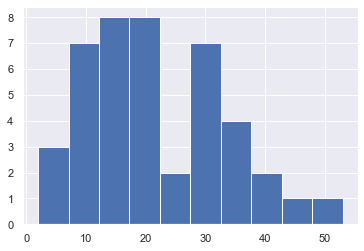

In [7]:
plt.hist(dfbg['cases'])

In [8]:
dfbg['cumcaseslog'] = np.log(dfbg['cumcases'])
#dfbg['pdlog'] = np.log(dfbg['passed_days'])
dfbg['caseslog'] = np.log(dfbg['cases'])

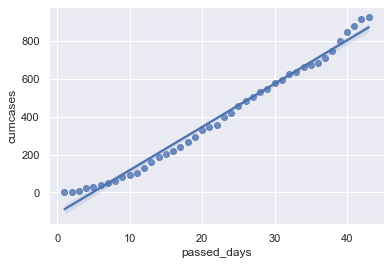

In [10]:
#let's see the linear fit 
sns.regplot(x="passed_days", y="cumcases", data=dfbg);

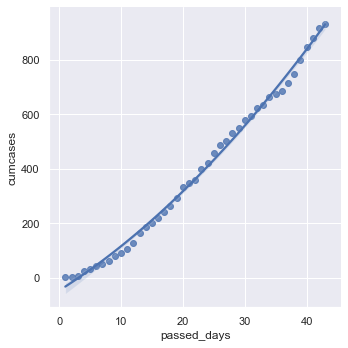

In [11]:
#second order polynomial
sns.lmplot(x="passed_days", y="cumcases", data=dfbg, order=2);

# regressions estimate to get an idea of what the parameters should be 

# SIR model estimate (exponential growth)

logC(t)= log(I(0))+log(α)+αt

                            OLS Regression Results                            
Dep. Variable:            cumcaseslog   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     149.8
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           2.83e-15
Time:                        11:40:56   Log-Likelihood:                -44.653
No. Observations:                  43   AIC:                             93.31
Df Residuals:                      41   BIC:                             96.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.0656      0.217     14.109      

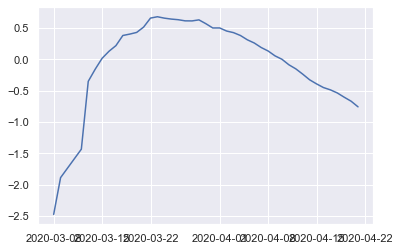

In [12]:
#estimating the coefficients of exponential growth: we will use them later as initial values to fit our model
exog = dfbg['passed_days']
exog = sm.add_constant(exog)
mod = sm.OLS(dfbg['cumcaseslog'], exog)
res = mod.fit()
print(res.summary())
plt.plot(res.resid)

In [13]:
#get the values for the exponential model
init = np.exp(res.params[0])
growth = np.exp(res.params[1])
print('initial value is ', init)
print('growth rate is ', growth)

initial value is  21.44789454394166
growth rate is  1.1110348221292772


# doubling time based on the SIR model

In [14]:
doubtime = np.log(2)/res.params[1]
print('the SIR double time is ', doubtime)

the SIR double time is  6.583103624661698


# polynomial model fit (this will be initial values later)

                            OLS Regression Results                            
Dep. Variable:               cumcases   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     5123.
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           6.26e-49
Time:                        11:41:35   Log-Likelihood:                -184.91
No. Observations:                  43   AIC:                             375.8
Df Residuals:                      40   BIC:                             381.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -47.1730      8.870     -5.318      

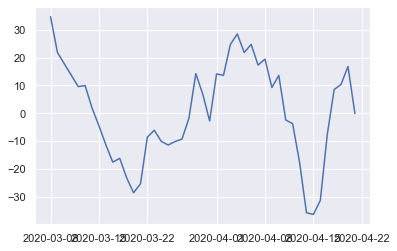

In [15]:
#we will use these again as initial values for the polyn2 model
dfbg['pdsq'] = dfbg['passed_days']**2
exog = dfbg[['passed_days', 'pdsq']]
exog = sm.add_constant(exog)
mod = sm.OLS(dfbg['cumcases'], exog)
res = mod.fit()
print(res.summary())
plt.plot(res.resid)

# List all the models we're about to try

In [16]:
def logistic(t, a, b, c):
    return c/(1+a*np.exp(-b*t))
def expon(t, a, b):
    return a*b**(t)
def linear(t, a, b):
    return a+b*t
def polyn(t, a, b, c):
    return a+b*t+c*(t**2)
def polyn3(t, a, b, c, d):
    return a+b*t+c*(t**2)+d*(t**3)

# Fitting Logistic Function

In [17]:
p0 = np.random.exponential(size=3)
bounds = (0, [1000, 4, 7000000])
x = np.array(dfbg['passed_days'])
y = np.array(dfbg['cumcases'])
(a11, b11, c11), cov = optim.curve_fit(logistic, x, y, bounds=bounds, p0=p0)
def log_pred(t):
    return c11/(1+a11*np.exp(-b11*t))

Text(0, 0.5, 'cumulative cases')

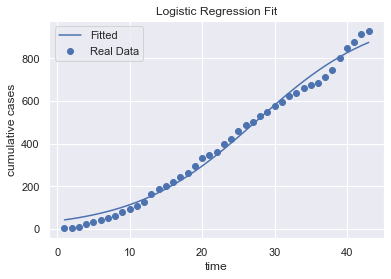

In [18]:
plt.scatter(x, y)
plt.plot(x, log_pred(x))
plt.title('Logistic Regression Fit')
plt.legend(['Fitted', 'Real Data'])
plt.xlabel('time')
plt.ylabel('cumulative cases')

Here we test the parameters (in particular the growth rate) for stability using rolling windows estimation. For each time window, we estimate 1000 parameters, so we can try to do some inference after.

In [19]:
b = np.zeros((20, 1000))
intial = 20
for i in range(0, 20):
    for k in range(0, 1000):
        p0 = np.random.exponential(size=3)
        bounds = (0, [1000, 4, 7000000])
        x = np.array(dfbg['passed_days'].iloc[len(dfbg)-intial:])
        y = np.array(dfbg['cumcases'].iloc[len(dfbg)-intial:])
        try:
            (a1, b1, c1), cov = optim.curve_fit(logistic, x, y, bounds=bounds, p0=p0)
            b[i, k] = b1
        except:
            k-=1
            continue
    intial-=1

C:\Users\GerganaM\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Let's try to get the 95% confidence interval using the formula for Normal distribution (does this follow from the CLT or it's a stretch??)

In [20]:
dfb = pd.DataFrame(b)
dfb['mean'] = dfb.mean(axis=1)
dfb['std'] = dfb.std(axis=1)
#assume normal distribution for the CI? does it follow from the CLT??
dfb['UB'] = dfb['mean']+1.960*dfb['std']/(np.sqrt(1000))
dfb['LB'] = dfb['mean']-1.960*dfb['std']/(np.sqrt(1000))
#plt.plot(dfbm)

We see on the graph below that the growth rate (which should control the spread of the pandemic is increasing with time. Can we conclude anything on the effect of the measures based on this?

Text(0, 0.5, 'Growth Rate value')

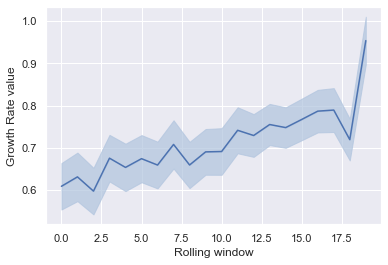

In [21]:
plt.plot()
plt.fill_between(dfb.index, dfb['mean'],dfb['UB'], alpha=0.7, color='lightsteelblue')
plt.plot(dfb.index, dfb['mean'])
plt.fill_between(dfb.index, dfb['mean'],dfb['LB'], alpha=0.7, color='lightsteelblue')
plt.xlabel('Rolling window')
plt.ylabel('Growth Rate value')

# Fitting Exponential Growth

In [26]:
p0 = np.random.normal(size=2)
#p0 = [1.2, 8]
bounds = (0, [1000, 20])
x = np.array(dfbg['passed_days'])
y = np.array(dfbg['cumcases'])
(a2, b2), cov = optim.curve_fit(expon, x, y, bounds=bounds, p0=p0)
def expon_pred(t):
    return a2*(b2**t)

Text(0, 0.5, 'cumulative cases')

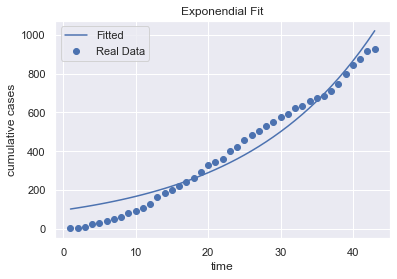

In [27]:
plt.scatter(x, y)
plt.plot(x, expon_pred(x))
plt.title('Exponendial Fit')
plt.legend(['Fitted', 'Real Data'])
plt.xlabel('time')
plt.ylabel('cumulative cases')

# Fitting Linear Growth

In [37]:
#p0 = np.random.normal(size=2)
p0 = [10, 10]
bounds = (0, [1000, 10000])
x = np.array(dfbg['passed_days'])
y = np.array(dfbg['cumcases'])
(a3, b3), cov = optim.curve_fit(linear, x, y, bounds=bounds, p0=p0)
def lin_pred(t):
    return a3+b3*t

Text(0, 0.5, 'cumulative cases')

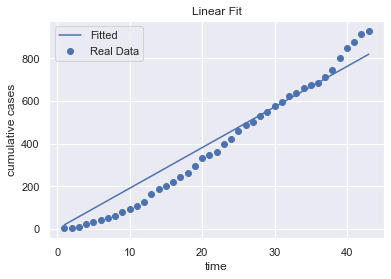

In [38]:
plt.scatter(x, y)
plt.plot(x, lin_pred(x))
plt.title('Linear Fit')
plt.legend(['Fitted', 'Real Data'])
plt.xlabel('time')
plt.ylabel('cumulative cases')

# polynomial of order 2

In [46]:
p0 = [0, 14, 0.2]
bounds = (0, [1000, 10000, 100])
x = np.array(dfbg['passed_days'])
y = np.array(dfbg['cumcases'])
(a4, b4, c4), cov = optim.curve_fit(polyn, x, y, bounds=bounds, p0=p0)
def polyn_pred(t):
    return a4+b4*t+c4*(t**2)

Text(0, 0.5, 'cumulative cases')

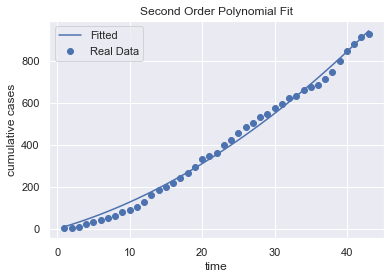

In [47]:
plt.scatter(x, y)
plt.plot(x, polyn_pred(x))
plt.title('Second Order Polynomial Fit')
plt.legend(['Fitted', 'Real Data'])
plt.xlabel('time')
plt.ylabel('cumulative cases')

# polynomial of order 3

In [48]:
p0 = [0, 10, 10, 10]
bounds = (0, [1000, 10000, 100, 100])
x = np.array(dfbg['passed_days'])
y = np.array(dfbg['cumcases'])
(a5, b5, c5, d), cov = optim.curve_fit(polyn3, x, y, bounds=bounds, p0=p0)
def polyn3_pred(t):
    return a5+b5*t+c5*(t**2)+d*(t**3)

Text(0, 0.5, 'cumulative cases')

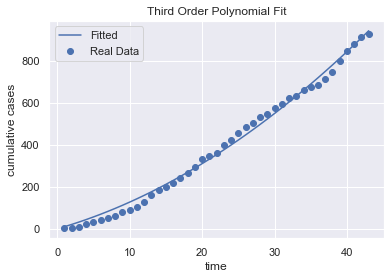

In [49]:
plt.scatter(x, y)
plt.plot(x, polyn3_pred(x))
plt.title('Third Order Polynomial Fit')
plt.legend(['Fitted', 'Real Data'])
plt.xlabel('time')
plt.ylabel('cumulative cases')

# combine all forecasts for the next 20 days 

In [50]:
columns = ['Data', 'Logistic', 'Exponential', 'Linear', 'Poly2', 'Poly3']

In [51]:
days = np.arange(1, len(dfbg)+20)
newindex = pd.date_range(dfbg.index[0], periods=len(days))
dfforecasts = pd.DataFrame(columns=columns, index=newindex)

In [52]:
dfforecasts['Logistic'] = log_pred(days)
dfforecasts['Exponential'] = expon_pred(days)
dfforecasts['Linear'] = lin_pred(days)
dfforecasts['Poly2'] = polyn_pred(days)
dfforecasts['Poly3'] = polyn3_pred(days)
dfforecasts['Data'] = dfbg['cumcases']

Text(0, 0.5, 'cumulative cases')

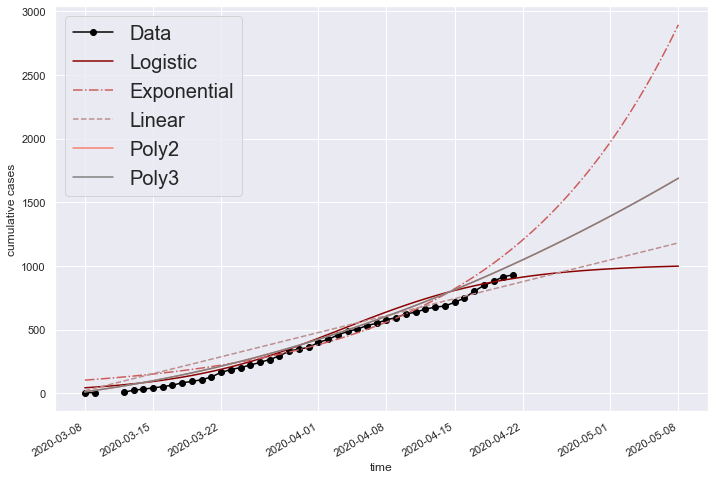

In [53]:
sns.set(font_scale=2) 
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.figure()

with pd.plotting.plot_params.use('x_compat', True):
    dfforecasts.Data.plot(color='black', marker='o')
    dfforecasts.Logistic.plot(color='darkred')
    dfforecasts.Exponential.plot(color='indianred', linestyle='-.')
    dfforecasts.Linear.plot(color='rosybrown', linestyle='--')
    dfforecasts.Poly2.plot(color='salmon')
    dfforecasts.Poly3.plot(color='gray')
plt.legend(list(dfforecasts), ncol=1, loc='upper left', fontsize=20)
plt.xlabel('time')
plt.ylabel('cumulative cases')